In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [550]:
import os
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import pyoneer as pynr

from tool_use import targets
from tool_use.models import Value
from tool_use.rollout import Rollout

# Improved Baseline Target

## Why does value loss start at 1 each iteration

$$ L = \frac{1}{n} \sum_{i = 0}^{n} (V(s) - A(s)_{\text{norm}} + \hat{V(s)})^2 $$

$$ L = \frac{1}{n} \sum_{i = 0}^{n} (\frac{A - A_{\text{mean}}}{A_{\text{std}}})^2 = 1 $$

https://en.wikipedia.org/wiki/Variance

$$ Var[X] = E[X^2] - E[X]^2 $$

$$ E[X^2] = Var[X] + E[X]^2 $$

In [27]:
X = np.random.normal(scale=1, size=1000000)

In [29]:
np.mean(X**2)

0.9996216398395751

# Samples

In [547]:
job_dir = '/Users/fomoro/jobs/tool_use/bipedalwalker-v2-1545364430'
discount_factor = 0.99
lambda_factor = 0.95
train_iters = 100

In [468]:
tf.enable_eager_execution()

In [548]:
env = gym.make('BipedalWalker-v2')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/fomoro/.local/share/virtualenvs/tool_use-bY6AXkXQ/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [470]:
def policy(state, training=None, reset_state=None):
    return env.action_space.sample()

In [471]:
rollout = Rollout(env, max_episode_steps=env.spec.max_episode_steps)

In [472]:
states, actions, rewards, next_states, weights = rollout(policy, episodes=1)

(0, 100)

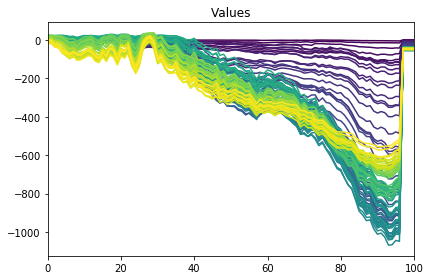

In [551]:
value = Value(observation_space=env.observation_space)
checkpoint = tf.train.Checkpoint(value=value)
colors = plt.cm.viridis(np.linspace(0, 1, train_iters))

for it in range(train_iters):
    ckpt = it + 1

    checkpoint_path = os.path.join(job_dir, 'ckpt-{}'.format(ckpt))
    checkpoint.restore(checkpoint_path)

    values = value(states)

    plt.plot(tf.transpose(values).numpy(), color=colors[it])

plt.title('Values')
plt.tight_layout()
plt.xlim(0, 100)

In [563]:
advantages = targets.compute_advantages(
    rewards=rewards,
    values=values,
    discount_factor=discount_factor,
    lambda_factor=lambda_factor,
    weights=weights) * weights
advantages_norm = pynr.math.weighted_moments_normalize(
    advantages, weights=weights) * weights
returns = targets.compute_improved_returns(
    advantages_norm=advantages_norm, values=values) * weights

In [564]:
weights[0, 87:97]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [565]:
rewards_next = tf.concat([rewards[:, 1:], rewards[:, -1:]], axis=1)
rewards_next[0, 87:97]

<tf.Tensor: id=7347547, shape=(10,), dtype=float32, numpy=
array([ 8.0090925e-02,  1.1995566e-01,  1.2754880e-01,  1.3890931e-01,
        5.9504278e-02,  6.0522802e-02,  1.7995914e-02, -8.8529781e-02,
       -1.0000000e+02,  0.0000000e+00], dtype=float32)>

In [566]:
rewards[0, 87:97]

array([ 2.6619239e-02,  8.0090925e-02,  1.1995566e-01,  1.2754880e-01,
        1.3890931e-01,  5.9504278e-02,  6.0522802e-02,  1.7995914e-02,
       -8.8529781e-02, -1.0000000e+02], dtype=float32)

In [567]:
rewards_next[0, 87:97] - rewards[0, 87:97]

<tf.Tensor: id=7347554, shape=(10,), dtype=float32, numpy=
array([ 5.3471684e-02,  3.9864734e-02,  7.5931400e-03,  1.1360511e-02,
       -7.9405032e-02,  1.0185242e-03, -4.2526886e-02, -1.0652570e-01,
       -9.9911469e+01,  1.0000000e+02], dtype=float32)>

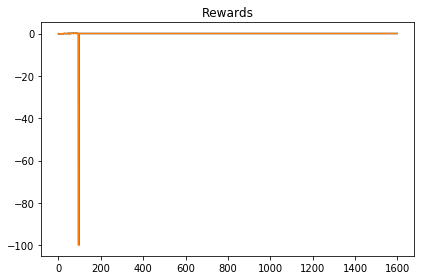

In [568]:
plt.plot(tf.transpose(rewards).numpy())
plt.plot(tf.transpose(rewards_next).numpy())
plt.title('Rewards')
plt.tight_layout()

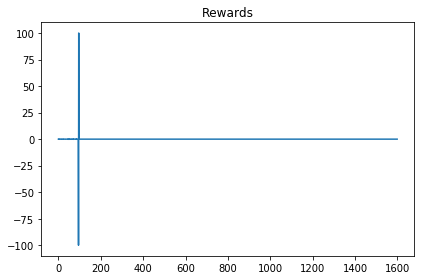

In [569]:
plt.plot(tf.transpose((rewards_next - rewards) * weights).numpy())
plt.title('Rewards')
plt.tight_layout()

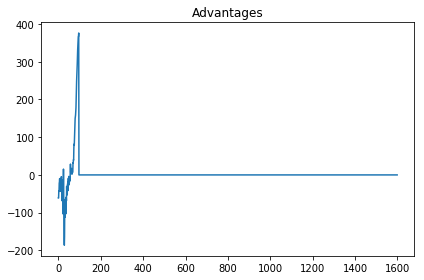

In [570]:
plt.plot(tf.transpose(advantages).numpy())
plt.title('Advantages')
plt.tight_layout()

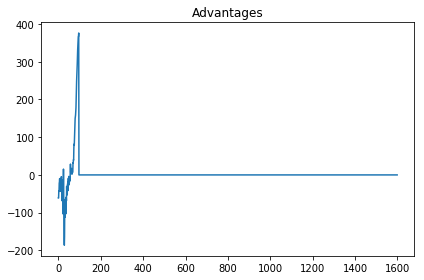

In [571]:
plt.plot(tf.transpose(advantages).numpy())
plt.title('Advantages')
plt.tight_layout()

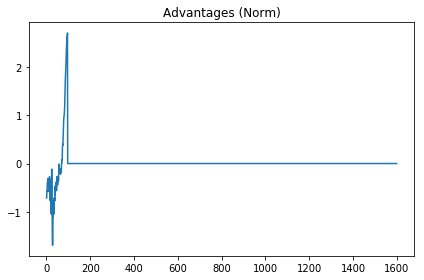

In [572]:
plt.plot(tf.transpose(advantages_norm).numpy())
plt.title('Advantages (Norm)')
plt.tight_layout()

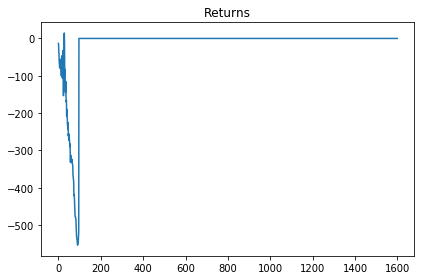

In [573]:
plt.plot(tf.transpose(returns).numpy())
plt.title('Returns')
plt.tight_layout()